In [ ]:
%%capture
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import time
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

!pip install transformers

from transformers import  AutoTokenizer, BertTokenizer,  AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) #Todos os valore e vetores são carregados na gpu, caso ela esteja disponível

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)

In [ ]:
def get_data(nome_arquivo,shuffle):
    ds = pd.read_csv(nome_arquivo,encoding="utf-8")
    if shuffle:
        ds = ds.sample(frac=1)
    ds['texto'] = ds['texto'].apply(str)
    return ds

stop = set(stopwords.words("portuguese"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

def remove_punct(text):
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    return text.translate(translator)

def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

def remove_hifen(text):
    translator = str.maketrans('-',' ')
    return text.translate(translator)

pattern = re.compile(r"https?//(\S+|www)\.\S+")
def pat(df_t):
    for t in df_t.texto:
        matches = pattern.findall(t)
        for match in  matches:
            print(t)
            print(match)
            print(pattern.sub(r"",t))        
        if len(matches)> 0:
            break

def make_test(df_t):
    df_t["texto"] = df_t.texto.map(remove_URL)
    df_t["texto"] = df_t.texto.map(remove_punct)
    df_t["texto"] = df_t.texto.map(remove_hifen)
    #df_t["texto"] = df_t.texto.map(remove_numbers)
    df_t["texto"] = df_t.texto.map(remove_stopwords)

def prepare(teste):
    teste = remove_URL(teste)
    teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

#counter = counter_word(df.texto)  

def prepare(teste):
    teste = remove_URL(teste)
    #teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

In [ ]:
train_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/train.csv'
eval_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/eval.csv'

In [ ]:
df = get_data(train_csv,1)
dt = get_data(eval_csv,0)

In [ ]:
pat(df)
make_test(df)
pat(dt)
make_test(dt)

In [ ]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X = X
        self.X = self.X.to(device)

        self.y = y
        self.y = self.y.to(device)

        self.len = len(y)

    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.X[:,idx],self.y[idx]

In [ ]:
df_tok = tokenizer.batch_encode_plus(df['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

In [ ]:
dt_tok = tokenizer.batch_encode_plus(dt['texto'].tolist(), max_length=150, truncation= True, padding="max_length", 
                                  add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'pt')

In [ ]:
X = torch.stack((df_tok['input_ids'],df_tok['attention_mask']),dim=0)
X_test = torch.stack((dt_tok['input_ids'],dt_tok['attention_mask']),dim=0)

In [ ]:
y = torch.Tensor(df['valor'].to_numpy())
y_test = torch.Tensor(dt['valor'].to_numpy())

In [ ]:
dataset = MyDataset(X,y)
teste_dataset = MyDataset(X_test,y_test)

In [ ]:
train_size = 0.9
val_size = 0.1
BATCH = 16

n_train = int(np.round(dataset.len*train_size))
n_val = int(np.round(dataset.len*val_size))

In [ ]:
train_slice, val_slice = torch.utils.data.random_split(dataset,[n_train,n_val])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_slice,batch_size=BATCH,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_slice,batch_size=BATCH,shuffle=True)

test_loader = torch.utils.data.DataLoader(teste_dataset,batch_size=1,shuffle=False)

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
class Modelo(nn.Module):
    def __init__(self,num_palavras:int, dimensao:int, pretrained_model):
        super(Modelo, self).__init__()
        self.pretrained = pretrained_model 
        self.shape1 = nn.Linear(in_features = num_palavras * dimensao, out_features=768)
        self.shape2 = nn.Linear(768, out_features = 1400)
        self.shape3 = nn.Linear(1400, out_features = 144)
        self.shape4 = nn.Linear(144, out_features = 128)
        self.shape5 = nn.Linear(128, out_features = 2)

    def forward(self,input_ids,input_masks):
        y = self.pretrained(input_ids,input_masks)
        y = y[0].flatten(start_dim=1)
        y = self.shape1(y)
        y = F.relu(self.shape2(y))
        y = F.relu(self.shape3(y))
        y = F.relu(self.shape4(y))
        y = F.dropout(self.shape5(y),p=0.01)
        return y

In [ ]:
modelo = Modelo(150,768,model).to(device)

In [ ]:
epocas = 10
steps = 200
validation = 20

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modelo.parameters(),lr=1e-6)
acc_calc = lambda output,labels : (labels == output.argmax(axis = 1)).sum()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim,0.9992)

In [ ]:
"""
def treinamento(epocas,train_loader,val_loader,modelo,optim,loss_fn,scheduler):
    for i in range(epocas):
      for step, (data,labels) in enumerate(train_loader):
        modelo.train()
        

        input_ids,input_masks = data[:,0,:], data[:,1,:]  

        output = modelo(input_ids,input_masks)

        #print(output.shape)
        #break
        optim.zero_grad()
        loss_train = loss_fn(output,labels.long())
        loss_train.backward()
        for step, (val_data,val_labels) in enumerate(val_loader):    
          with torch.no_grad():
              modelo.eval()

              t_input_ids,t_input_masks = val_data[:,0,:], val_data[:,1,:]  

              output_val  = modelo(t_input_ids,t_input_masks)
              loss_val = loss_fn(output_val,val_labels.long())    
        
        optim.step()
        scheduler.step()

      print(f'ÉPOCA: {i} Loss: {loss_train}')  
"""     

"\ndef treinamento(epocas,train_loader,val_loader,modelo,optim,loss_fn,scheduler):\n    for i in range(epocas):\n      for step, (data,labels) in enumerate(train_loader):\n        modelo.train()\n        \n\n        input_ids,input_masks = data[:,0,:], data[:,1,:]  \n\n        output = modelo(input_ids,input_masks)\n\n        #print(output.shape)\n        #break\n        optim.zero_grad()\n        loss_train = loss_fn(output,labels.long())\n        loss_train.backward()\n        for step, (val_data,val_labels) in enumerate(val_loader):    \n          with torch.no_grad():\n              modelo.eval()\n\n              t_input_ids,t_input_masks = val_data[:,0,:], val_data[:,1,:]  \n\n              output_val  = modelo(t_input_ids,t_input_masks)\n              loss_val = loss_fn(output_val,val_labels.long())    \n        \n        optim.step()\n        scheduler.step()\n\n      print(f'ÉPOCA: {i} Loss: {loss_train}')  \n"

In [ ]:
#treinamento(epocas=epocas,train_loader=train_loader,val_loader=val_loader,modelo=modelo,optim=optim,loss_fn=loss_fn,scheduler=scheduler)

In [ ]:
hist_train_acc = []
hist_train_loss = []
hist_val_acc = []
hist_val_loss = []

for i in range(epocas):
  n_train_ex = 0
  n_val_ex = 0
  train_hit = 0
  val_hit = 0

  n_test_ex = 0
  test_hits = 0
  test_hit = []
  test_loss = 0

  for step, (data,labels) in enumerate(train_loader):
    modelo.train()
    train_loss = 0

    input_ids,input_masks = data[:,0,:], data[:,1,:]  

    output = modelo(input_ids,input_masks)
    
    optim.zero_grad()
    loss_train = loss_fn(output,labels.long())

    train_loss += loss_train.item()
    softmax_pred = nn.functional.softmax(output,dim=1)
    train_hit +=  acc_calc(softmax_pred,labels)  
  
    loss_train.backward()
    optim.step()

    n_train_ex += data.shape[0]

    if (step + 1) % steps == 0:
          #train_bar.close()
          break
    
    scheduler.step()
  
  for batch_num, (features,labels) in enumerate(val_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            outputs = modelo(input_ids,input_masks)

            loss = loss_fn(outputs,labels.long())

            test_loss += loss.item()

            softmax_pred = F.softmax(outputs,dim=1)
            test_hits += acc_calc(softmax_pred,labels)
            test_hit.append(acc_calc(softmax_pred,labels).item())

            n_test_ex += features.shape[0]
        if (step + 1) % validation == 0:
          #train_bar.close()
          break
  
  
  for step, (val_data,val_labels) in enumerate(val_loader):    
    with torch.no_grad():
        modelo.eval()
        val_loss = 0

        t_input_ids,t_input_masks = val_data[:,0,:], val_data[:,1,:]  

        output_val  = modelo(t_input_ids,t_input_masks)
        loss_val = loss_fn(output_val,val_labels.long())   

        val_loss += loss_val.item()
        softmax_pred2 = F.softmax(output_val,dim=1)
        val_hit += acc_calc(softmax_pred2,val_labels)

        #val_bar.update(1)

        n_val_ex += data.shape[0]
        if (step + 1) % validation == 0:
          #train_bar.close()
          break  
  

  train_acc = torch.true_divide(train_hit,n_train_ex)
  test_acc = torch.true_divide(test_hits,n_test_ex)
  val_acc = torch.true_divide(val_hit,n_val_ex)

  print(f'\nÉPOCA - {i+1}\t Train loss: {round(train_loss,4)}\t Train Acc: {round(train_acc.item(),4)}\t Val loss:{round(val_loss,4)}\t Val Acc: {round(test_acc.item(),4)}')
  
  hist_train_acc.append(train_acc.item())
  hist_train_loss.append(train_loss)
  hist_val_acc.append(test_acc.item())
  hist_val_loss.append(val_loss)


ÉPOCA - 1	 Train loss: 0.6807	 Train Acc: 0.5136	 Val loss:0.6707	 Val Acc: 0.4268

ÉPOCA - 2	 Train loss: 0.656	 Train Acc: 0.7019	 Val loss:0.6734	 Val Acc: 0.7195

ÉPOCA - 3	 Train loss: 0.6655	 Train Acc: 0.8198	 Val loss:0.6463	 Val Acc: 0.7805

ÉPOCA - 4	 Train loss: 0.6701	 Train Acc: 0.8238	 Val loss:0.6818	 Val Acc: 0.8293

ÉPOCA - 5	 Train loss: 0.5565	 Train Acc: 0.8388	 Val loss:0.6115	 Val Acc: 0.7561

ÉPOCA - 6	 Train loss: 0.5922	 Train Acc: 0.8509	 Val loss:0.4935	 Val Acc: 0.8049

ÉPOCA - 7	 Train loss: 0.6463	 Train Acc: 0.8794	 Val loss:0.7009	 Val Acc: 0.7683

ÉPOCA - 8	 Train loss: 0.5905	 Train Acc: 0.8767	 Val loss:0.8089	 Val Acc: 0.8293

ÉPOCA - 9	 Train loss: 0.4411	 Train Acc: 0.8862	 Val loss:0.606	 Val Acc: 0.8171

ÉPOCA - 10	 Train loss: 0.7051	 Train Acc: 0.8862	 Val loss:0.5222	 Val Acc: 0.7927


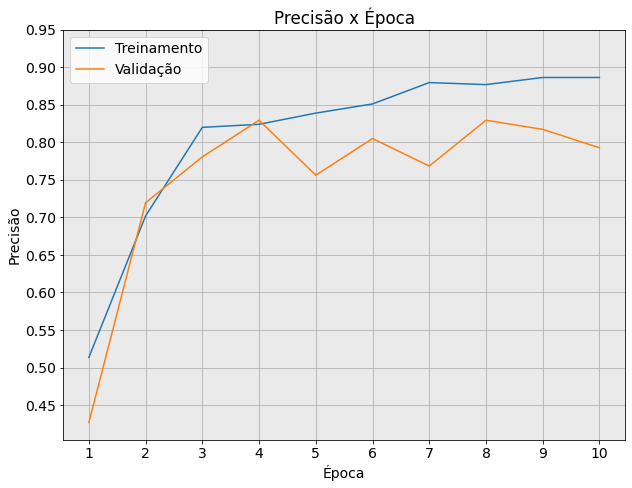

In [ ]:
hist_epoca = np.arange(1,epocas+1,1)
hist_train = pd.DataFrame({"Precisão":hist_train_acc,"Época":hist_epoca})
hist_val = pd.DataFrame({"Precisão":hist_val_acc,"Época":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams["font.style"] = 'normal'
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Época", y = "Precisão",data= hist_train)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Época", y = "Precisão",data= hist_val)
plt.legend(labels=['Treinamento', 'Validação'])
plt.yticks(np.arange(0.45,1,0.05))
x = np.arange(1,epocas+1,1)
#plt.xticks(x,hist_train['Época'])
plt.xticks(np.arange(1,epocas+1,1))
plt.title("Precisão x Época")
plt.grid()
#plt.suptitle("Precisão x Época",fontweight='bold')
plt.show()

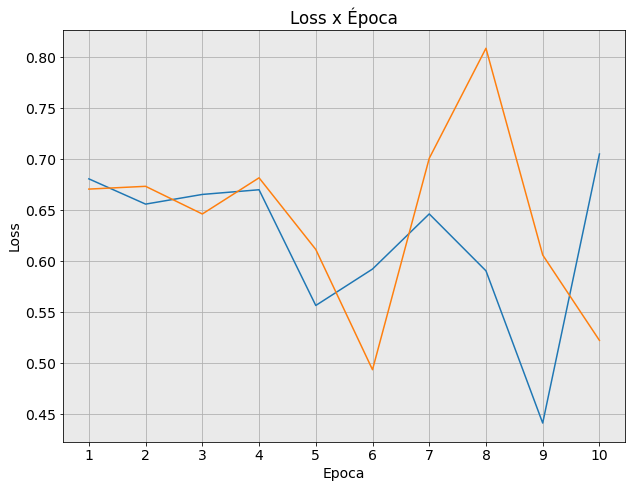

In [ ]:
hist_train_l = pd.DataFrame({"Loss":hist_train_loss,"Epoca":hist_epoca})
hist_val_l = pd.DataFrame({"Loss":hist_val_loss,"Epoca":hist_epoca})
plt.rcParams["figure.figsize"] = [9.00, 7.00]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.titleweight"] = 10
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
ax = sns.lineplot(x = "Epoca", y = "Loss",data= hist_train_l)
ax.set_facecolor('#EAEAEA')
ax1 = sns.lineplot(x = "Epoca", y = "Loss",data= hist_val_l)
plt.title("Loss x Época")
x = np.arange(1,11,1)
#plt.xticks(x,hist_epoca)
plt.xticks(np.arange(1,epocas+1,1))
#plt.yticks(np.arange(0.1,0.8,0.05))
plt.grid()
plt.show()

In [ ]:

n_test_ex = 0
test_hits = 0
test_hit = []

test_loss = 0

for batch_num, (features,labels) in enumerate(test_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            outputs = modelo(input_ids,input_masks)

            loss = loss_fn(outputs,labels.long())

            test_loss += loss.item()

            softmax_pred = F.softmax(outputs,dim=1)
            test_hits += acc_calc(softmax_pred,labels)
            test_hit.append(acc_calc(softmax_pred,labels).item())

            n_test_ex += features.shape[0]
        


In [ ]:
test_acc = torch.true_divide(test_hits,n_test_ex)
test_acc

tensor(0.8750, device='cuda:0')

In [ ]:
test_hit,y_test

([1, 1, 0, 1, 1, 1, 1, 1], tensor([1., 1., 1., 1., 0., 0., 0., 0.]))

In [ ]:
def prediction(text:str) -> str:
    text = prepare(text)
    batch = tokenizer(text,padding='max_length',max_length = 150,truncation = True,return_tensors='pt').to(device)
    disciplinas = {0:"Eletrica",1:"Eletrônica"}
    with torch.no_grad():
        outputs = modelo(batch['input_ids'],batch['attention_mask'])
        #print(outputs)
        
        predictions = F.softmax(outputs,dim=1)
        #print(predictions)
        labels = torch.argmax(predictions,dim=1)
        print(labels.item())
        return disciplinas.get(labels.item())  

In [ ]:
text = dt['texto'][0]
batch = tokenizer(text,padding=True,truncation=True,max_length=150,return_tensors="pt").to(device)

In [ ]:
n_test_ex = 0
test_hits = 0
test_hit = []

test_loss = 0
for ep in range(epocas):
  for batch_num, (features,labels) in enumerate(val_loader):
        
        with torch.no_grad():
            val_loss = 0

            model.eval()

            input_ids,input_masks = features [:,0,:],features[:,1,:]

            outputs = modelo(input_ids,input_masks)

            loss = loss_fn(outputs,labels.long())

            test_loss += loss.item()

            softmax_pred = F.softmax(outputs,dim=1)
            test_hits += acc_calc(softmax_pred,labels)
            test_hit.append(acc_calc(softmax_pred,labels).item())

            n_test_ex += features.shape[0]
        #print(torch.argmax(softmax_pred))
  test_acc = torch.true_divide(test_hits,n_test_ex)
  print(test_acc)


tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.8171, device='cuda:0')


In [ ]:
test_acc = torch.true_divide(test_hits,n_test_ex)
test_acc

tensor(0.8171, device='cuda:0')

In [ ]:
for label,text in zip(y_test,dt['texto']):
  print(prediction(text=text)," ",label)


1
Eletrônica   tensor(1.)
1
Eletrônica   tensor(1.)
0
Eletrica   tensor(1.)
1
Eletrônica   tensor(1.)
0
Eletrica   tensor(0.)
0
Eletrica   tensor(0.)
0
Eletrica   tensor(0.)
0
Eletrica   tensor(0.)


In [ ]:
teste_1 = """O objetivo deste trabalho é propor um algoritmo para realizar a 
identificação de padrões na vocalização suína, visando determinar o nível do 
bem-estar do animal. Tal análise foi proposta uma vez que o bem-estar animal é 
um assunto cada vez mais abordado no mundo todo, principalmente quando os animais 
são criados para o abate. Dessa forma, a criação de um método em que haja o mínimo 
de contato com os animais se faz importante, evitando que tal contato altere o 
comportamento do animal e, conseqüentemente, o resultado da análise de seu bem-estar. 
Por essas características, foi proposto um método de análise dos sons emitidos pelos 
suínos com base na utilização de uma Rede Neural Artificial do tipo Radial Basis Function,
 como elementos de treinamento e operação um conjunto de características extraídas através
 ormada Discreta Wavelet de sinais sonoros pré-gravados. As características obtidas dos
sinais foram as energias das bandas críticas relativas à Escala Bark e a diferença 
entre as energias das bandas adjacentes, além dimensão fractal do sinal. Através
desse método foram analisados dois tipos de sinais sonoros: a vocalização de
leitões saudáveis e de leitões acometidos por uma doença chamada Artrite Traumática; 
 e a vocalização de suínos adultos em situações de conforto e desconforto. Os 
resultados demonstram que a análise proposta atingiu bons patamares de acerto na
determinação do bem-estar do animal"""
#eletronica 1

In [ ]:
prediction(teste_1)

1


'Eletrônica'

In [ ]:
teste_2 = """Produzindo inicialmente motores elétricos, a WEG ampliou 
suas atividades a partir da década de 80, com a produção de componentes 
eletroeletrônicos, produtos para automação industrial, transformadores de
 força e distribuição, tintas líquidas e em pó e vernizes eletroisolantes. 
 A empresa se consolidou não só como fabricante de motores, mas como fornecedora 
 de sistemas elétricos industriais completos."""
 #eletrica 0

In [ ]:
prediction(teste_1)

1


'Eletrônica'

In [ ]:
teste_3 = """Numa definição mais abrangente, podemos dizer que a eletrônica é o 
ramo da ciência que estuda o uso de circuitos formados por componentes elétricos
 e eletrônicos, com o objetivo principal de representar, armazenar, transmitir 
 ou processar informações além do controle de processos e servomecanismos. Sob 
 esta ótica, também se pode afirmar que os circuitos internos dos computadores 
 (que armazenam e processam informações), os sistemas de telecomunicações (que 
transmitem informações), os diversos tipos de sensores e transdutores (que representam
grandezas físicas - informações - sob forma de sinais elétricos) estão, todos, dentro 
da área de interesse da eletrônica."""
#eletronica1

In [ ]:
prediction(teste_1)

1


'Eletrônica'

In [ ]:
teste_4 = """projeto visa nova abordagem sistema vigilância móvel autônomo. pulseira 
biométrica coleta dados sobre batimento cardíaco usuário envia, via bluetooth, módulo
processamento, smartphone sistema operacional android, faz análise destes batimentos 
cardíacos define usuário passando alguma situação risco morte, extremo estresse. 
smartphone escreve, periodicamente, informações tempo imediato sobre usuário, localização
ica batimentos cardíacos, banco dados nuvem que, vez, contém informações pessoais usuário, 
tipo sanguíneo, telefone contato emergencial, alergias, outros. premissa dados nuvem
 acessíveis todo momento servidor externo servirem base socorro médico emergencial,
  seja, sistema visa prover auxílio imediato maneira proativa autônoma, modo preservar 
  vidas, sendo baixo custo alcançável grande parte população. realizados diversos testes 
  simulações demonstrando adequabilidade sistema proposto situações problema apresentadas"""
#eletronica 1

In [ ]:
prediction(teste_1)

1


'Eletrônica'